In [2]:
# CELL 1: Cài đặt và Import thư viện

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import joblib
import scipy.sparse
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

# Thêm đường dẫn thư mục `src`
SRC_PATH = Path().resolve().parent / 'src'
sys.path.append(str(SRC_PATH))

# Import các hàm và class cần thiết từ các module đã xây dựng
from utils import MODEL_DIR, RESULT_DIR, DATA_DIR
from evaluate import (
    find_best_model_from_results, 
    evaluate_pipeline_gold,
    MedicalKnowledgePipeline
)

# Cài đặt cấu hình cho plots
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Segoe UI'
plt.rcParams['axes.unicode_minus'] = False

c:\Users\ASUS\anaconda3\envs\mynewenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


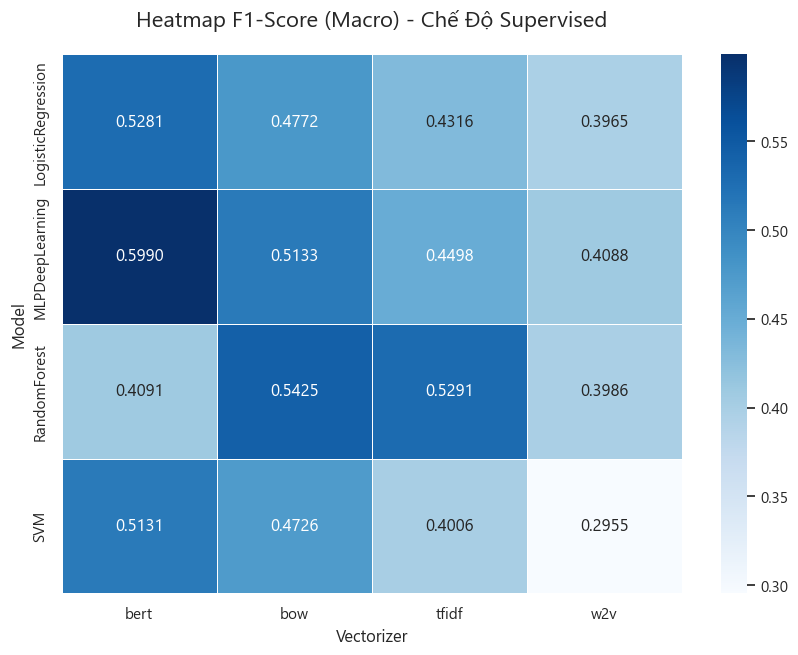

In [4]:
# CELL 2: Heatmap kết quả Standard

standard_csv_path = os.path.join(RESULT_DIR, 'model_comparison.csv')

try:
    df_std = pd.read_csv(standard_csv_path)
    
    # Pivot table để tạo ma trận cho heatmap
    pivot_std = df_std.pivot(index='Model', columns='Vectorizer', values='F1_Macro')
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(pivot_std, annot=True, fmt=".4f", cmap="Blues", linewidths=.5)
    plt.title('Heatmap F1-Score (Macro) - Chế Độ Supervised', fontsize=16, pad=20)
    plt.xlabel('Vectorizer', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.show()

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file kết quả '{standard_csv_path}'. Vui lòng chạy 'train_re.py' trước.")
    df_std = pd.DataFrame()

Loaded Best Config (Supervised): MLPDeepLearning (Vec: bert) - F1: 0.5990


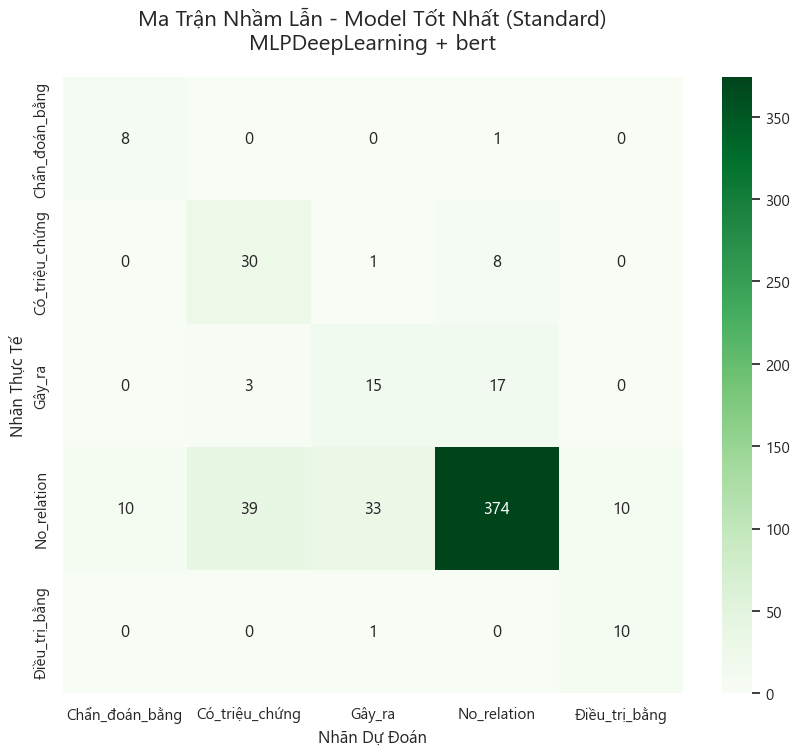


Báo Cáo Phân Loại Chi Tiết (Standard):

                precision    recall  f1-score   support

Chẩn_đoán_bằng       0.44      0.89      0.59         9
Có_triệu_chứng       0.42      0.77      0.54        39
        Gây_ra       0.30      0.43      0.35        35
   No_relation       0.94      0.80      0.86       466
 Điều_trị_bằng       0.50      0.91      0.65        11

      accuracy                           0.78       560
     macro avg       0.52      0.76      0.60       560
  weighted avg       0.84      0.78      0.80       560



In [5]:
# CELL 3: Ma trận nhầm lẫn và chỉ số của model Standard tốt nhất

if not df_std.empty:
    # 1. Tìm model tốt nhất
    best_model_std, best_vec_std = find_best_model_from_results(use_silver=False)

    # 2. Load các tài nguyên cần thiết để dự đoán lại trên tập test
    model_path = os.path.join(MODEL_DIR, f"{best_model_std}_{best_vec_std}.pkl")
    le_path = os.path.join(MODEL_DIR, 'label_encoder.pkl')
    test_csv_path = os.path.join(DATA_DIR, 'processed', 'test_data.csv')
    
    # Load vector test tương ứng
    if best_vec_std in ['bow', 'tfidf']:
        X_test = scipy.sparse.load_npz(os.path.join(MODEL_DIR, f'X_test_{best_vec_std}.npz'))
    else:
        X_test = np.load(os.path.join(MODEL_DIR, f'X_test_{best_vec_std}.npy'))

    # Load scaler nếu có
    scaler_path = os.path.join(MODEL_DIR, f'scaler_{best_vec_std}.pkl')
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        if scipy.sparse.issparse(X_test): X_test = X_test.toarray()
        X_test = scaler.transform(X_test)
        
    clf = joblib.load(model_path)
    le = joblib.load(le_path)
    df_test = pd.read_csv(test_csv_path)
    y_true = le.transform(df_test['relation_label'].fillna("No_relation"))
    
    # 3. Dự đoán
    y_pred = clf.predict(X_test)
    
    # 4. Trực quan hóa ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Ma Trận Nhầm Lẫn - Model Tốt Nhất (Standard)\n{best_model_std} + {best_vec_std}', fontsize=16, pad=20)
    plt.xlabel('Nhãn Dự Đoán', fontsize=12)
    plt.ylabel('Nhãn Thực Tế', fontsize=12)
    plt.show()

    # 5. In báo cáo chi tiết
    print("\nBáo Cáo Phân Loại Chi Tiết (Standard):\n")
    print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

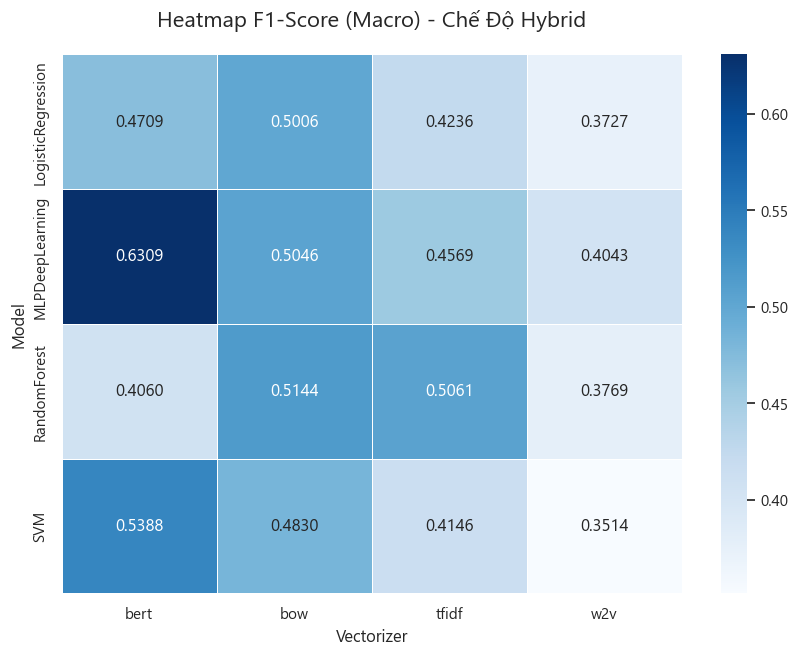

In [6]:
# CELL 4: Heatmap kết quả Hybrid

hybrid_csv_path = os.path.join(RESULT_DIR, 'model_comparison_hybrid.csv')

try:
    df_hyb = pd.read_csv(hybrid_csv_path)
    
    pivot_hyb = df_hyb.pivot(index='Model', columns='Vectorizer', values='F1_Macro')
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(pivot_hyb, annot=True, fmt=".4f", cmap="Blues", linewidths=.5)
    plt.title('Heatmap F1-Score (Macro) - Chế Độ Hybrid', fontsize=16, pad=20)
    plt.xlabel('Vectorizer', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.show()

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file kết quả '{hybrid_csv_path}'. Vui lòng chạy 'train_re.py --use_silver' trước.")
    df_hyb = pd.DataFrame()

Loaded Best Config (Hybrid): MLPDeepLearning (Vec: bert) - F1: 0.6309


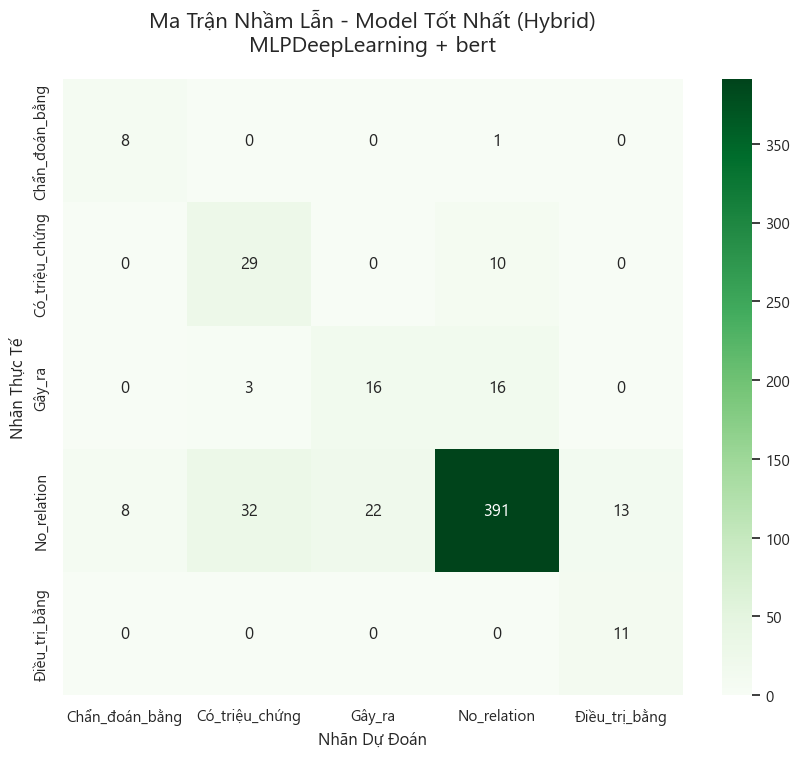


Báo Cáo Phân Loại Chi Tiết (Hybrid):

                precision    recall  f1-score   support

Chẩn_đoán_bằng       0.50      0.89      0.64         9
Có_triệu_chứng       0.45      0.74      0.56        39
        Gây_ra       0.42      0.46      0.44        35
   No_relation       0.94      0.84      0.88       466
 Điều_trị_bằng       0.46      1.00      0.63        11

      accuracy                           0.81       560
     macro avg       0.55      0.79      0.63       560
  weighted avg       0.85      0.81      0.83       560



In [ ]:
# CELL 5: Ma trận nhầm lẫn và chỉ số của model Hybrid tốt nhất

if not df_hyb.empty:
    best_model_hyb, best_vec_hyb = find_best_model_from_results(use_silver=True)

    model_path = os.path.join(MODEL_DIR, f"{best_model_hyb}_{best_vec_hyb}_hybrid.pkl")
    le_path = os.path.join(MODEL_DIR, 'label_encoder_hybrid.pkl')
    
    if best_vec_hyb in ['bow', 'tfidf']:
        X_test = scipy.sparse.load_npz(os.path.join(MODEL_DIR, f'X_test_{best_vec_hyb}.npz'))
    else:
        X_test = np.load(os.path.join(MODEL_DIR, f'X_test_{best_vec_hyb}.npy'))

    scaler_path = os.path.join(MODEL_DIR, f'scaler_{best_vec_hyb}_hybrid.pkl')
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        if scipy.sparse.issparse(X_test): X_test = X_test.toarray()
        X_test = scaler.transform(X_test)
        
    clf = joblib.load(model_path)
    le = joblib.load(le_path)
    y_pred = clf.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Ma Trận Nhầm Lẫn - Model Tốt Nhất (Hybrid)\n{best_model_hyb} + {best_vec_hyb}', fontsize=16, pad=20)
    plt.xlabel('Nhãn Dự Đoán', fontsize=12)
    plt.ylabel('Nhãn Thực Tế', fontsize=12)
    plt.show()

    print("\nBáo Cáo Phân Loại Chi Tiết (Hybrid):\n")
    print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

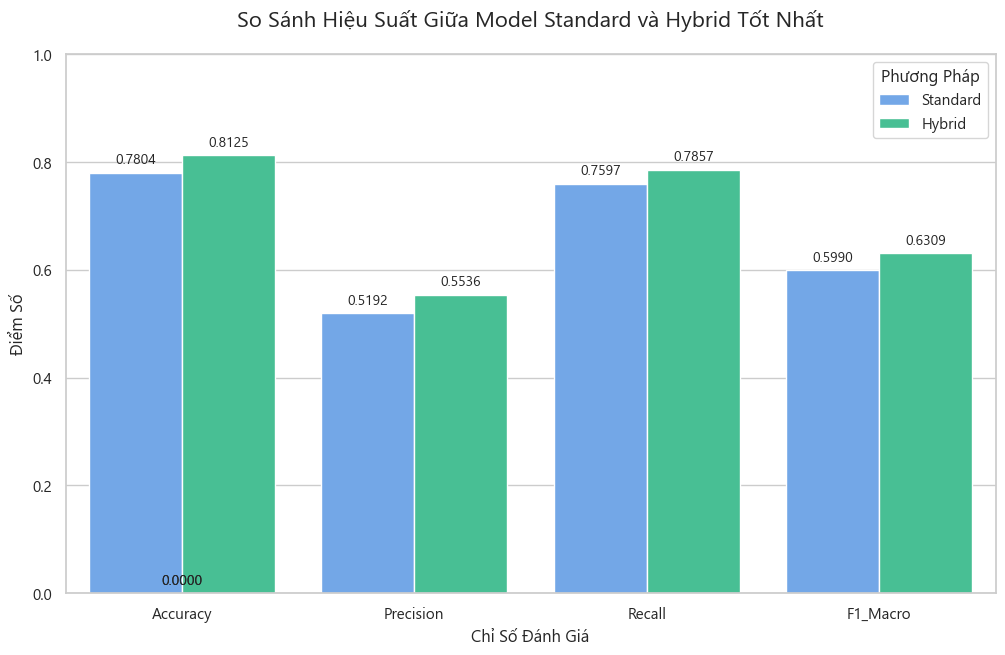

In [ ]:
# CELL 6: So sánh trực tiếp Standard vs. Hybrid

if not df_std.empty and not df_hyb.empty:
    # Lấy thông tin từ DataFrame kết quả
    best_std_metrics = df_std.loc[df_std['F1_Macro'].idxmax()].add_prefix('Standard_')
    best_hyb_metrics = df_hyb.loc[df_hyb['F1_Macro'].idxmax()].add_prefix('Hybrid_')

    # Tạo DataFrame để vẽ biểu đồ
    comparison_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1_Macro'],
        'Standard': [best_std_metrics['Standard_Accuracy'], best_std_metrics['Standard_Precision'], best_std_metrics['Standard_Recall'], best_std_metrics['Standard_F1_Macro']],
        'Hybrid': [best_hyb_metrics['Hybrid_Accuracy'], best_hyb_metrics['Hybrid_Precision'], best_hyb_metrics['Hybrid_Recall'], best_hyb_metrics['Hybrid_F1_Macro']]
    }
    df_comp = pd.DataFrame(comparison_data).melt(id_vars='Metric', var_name='Phương Pháp', value_name='Điểm Số')

    plt.figure(figsize=(12, 7))
    ax = sns.barplot(data=df_comp, x='Metric', y='Điểm Số', hue='Phương Pháp', palette={'Standard': '#60a5fa', 'Hybrid': '#34d399'})
    ax.set_title('So Sánh Hiệu Suất Giữa Model Standard và Hybrid Tốt Nhất', fontsize=16, pad=20)
    ax.set_ylim(0, 1.0)
    ax.set_xlabel('Chỉ Số Đánh Giá', fontsize=12)
    ax.set_ylabel('Điểm Số', fontsize=12)
    
    # Hiển thị số liệu
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=10)

    plt.legend(title='Phương Pháp')
    plt.show()

In [ ]:
# CELL 7: Đánh giá pipeline hoàn chỉnh

if not df_hyb.empty:
    print("--- Đánh Giá Pipeline Hoàn Chỉnh (NER + RE) ---")
    
    # Lấy thông tin model tốt nhất từ Hybrid
    best_model, best_vec = best_model_hyb, best_vec_hyb
    
    # Đường dẫn tới mô hình NER và file test JSON
    ner_model_path = os.path.join(MODEL_DIR, 'ner_spacy_model')
    test_json_path = os.path.join(DATA_DIR, 'processed', 'test_tasks.json')
    
    # Gọi hàm đánh giá pipeline từ evaluate.py
    pipeline_f1 = evaluate_pipeline_gold(
        ner_model_path=ner_model_path,
        re_model_name=best_model,
        vec_name=best_vec,
        use_silver=True  # Quan trọng: Dùng model hybrid
    )
    
    print(f"\n>>> KẾT QUẢ CUỐI CÙNG: F1-Score của toàn pipeline là: {pipeline_f1:.4f}")

--- Đánh Giá Pipeline Hoàn Chỉnh (NER + RE) ---

--- PIPELINE EVALUATION (Gold Standard Comparison) ---
--- Initializing Pipeline: RE=MLPDeepLearning (bert) ---
Loading SpaCy model from: D:\levy\Nam 3\NLP\medical-re\models\ner_spacy_model
Đang tải tài nguyên RE: MLPDeepLearning (bert) [Hybrid=True]


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Result: Gold=94, Pred=66, Correct=43
Pipeline F1: 0.5375 (Precision=0.6515, Recall=0.4574)

>>> KẾT QUẢ CUỐI CÙNG: F1-Score của toàn pipeline là: 0.5375


In [ ]:
# CELL 8: Demo Pipeline

if not df_hyb.empty:
    # 1. Khởi tạo pipeline với model tốt nhất
    print("Đang khởi tạo pipeline với mô hình tốt nhất...")
    final_pipeline = MedicalKnowledgePipeline(
        ner_model_path=os.path.join(MODEL_DIR, 'ner_spacy_model'),
        re_model_name=best_model_hyb,
        vec_name=best_vec_hyb,
        use_silver=True
    )
    print("Pipeline đã sẵn sàng!")
    
    # 2. Văn bản đầu vào
    input_text = """
    Bệnh tiểu đường type 2 là một rối loạn chuyển hóa đặc trưng bởi tình trạng tăng đường huyết.
    Nguyên nhân chính là do đề kháng insulin và thiếu hụt insulin tương đối, thường liên quan đến béo phì và lối sống ít vận động.
    Các triệu chứng phổ biến của bệnh tiểu đường bao gồm khát nước nhiều, đi tiểu thường xuyên và mệt mỏi.
    Để chẩn đoán, bác sĩ thường chỉ định xét nghiệm HbA1c.
    Việc điều trị tiểu đường type 2 bao gồm thay đổi lối sống và sử dụng thuốc, trong đó Metformin là lựa chọn hàng đầu.
    """
    
    # 3. Chạy pipeline và in kết quả
    print("\n--- KẾT QUẢ TRÍCH XUẤT ---")
    print(f"Đoạn văn bản đầu vào:\n{input_text}\n")
    
    entities, relations = final_pipeline.process_text(input_text)
    
    print(">>> (1) Các thực thể được nhận dạng (NER):")
    if not entities:
        print("Không tìm thấy thực thể nào.")
    else:
        for ent in entities:
            print(f"- '{ent['text']}' ({ent['label']})")
            
    print("\n>>> (2) Các quan hệ được trích xuất (RE):")
    if not relations:
        print("Không tìm thấy quan hệ nào.")
    else:
        for rel in relations:
            print(f"- ({rel['subject']}) --[{rel['relation']}]--> ({rel['object']})")

Đang khởi tạo pipeline với mô hình tốt nhất...
--- Initializing Pipeline: RE=MLPDeepLearning (bert) ---
Loading SpaCy model from: D:\levy\Nam 3\NLP\medical-re\models\ner_spacy_model
Đang tải tài nguyên RE: MLPDeepLearning (bert) [Hybrid=True]
Pipeline đã sẵn sàng!

--- KẾT QUẢ TRÍCH XUẤT ---
Đoạn văn bản đầu vào:

    Bệnh tiểu đường type 2 là một rối loạn chuyển hóa đặc trưng bởi tình trạng tăng đường huyết.
    Nguyên nhân chính là do đề kháng insulin và thiếu hụt insulin tương đối, thường liên quan đến béo phì và lối sống ít vận động.
    Các triệu chứng phổ biến của bệnh tiểu đường bao gồm khát nước nhiều, đi tiểu thường xuyên và mệt mỏi.
    Để chẩn đoán, bác sĩ thường chỉ định xét nghiệm HbA1c.
    Việc điều trị tiểu đường type 2 bao gồm thay đổi lối sống và sử dụng thuốc, trong đó Metformin là lựa chọn hàng đầu.
    

>>> (1) Các thực thể được nhận dạng (NER):
- 'Bệnh tiểu đường type 2' (Bệnh)
- 'tăng đường huyết' (Triệu chứng)
- 'liên quan đến béo phì' (Chẩn đoán)
- 'lối sống í